# 1. Data Augmentation Layer

Les permutations aléatoires de SMILES et les tautomères ne changent pas les propriétés chimiques fondamentales de la molécule, mais il est important de comprendre les différences entre les deux :


### 1. Permutations aléatoires de SMILES :

- Les permutations aléatoires de SMILES génèrent différentes représentations linéaires de la même molécule. Elles ne changent pas la structure chimique ou les propriétés chimiques de la molécule. Elles sont simplement des réarrangements de la notation SMILES.
- source : https://www.rdkit.org/docs/source/rdkit.Chem.rdmolfiles.html#rdkit.Chem.rdmolfiles.MolToSmiles
  
### 2. Tautomères :

- Les tautomères sont des isomères de la même molécule qui diffèrent par la position des protons et des doubles liaisons. Bien que les tautomères aient les mêmes atomes et la même formule moléculaire, ils peuvent avoir des propriétés chimiques légèrement différentes en raison de la répartition différente des électrons.
- source :https://en.wikipedia.org/wiki/Tautomer

### 3. Remplacement par un groupe chimique de la meme classe fonctionnel

Remplacer un groupe fonctionnel par un autre de la même classe chimique. Par exemple, remplacer un groupe hydroxyle par un groupe méthoxy tout en conservant les propriétés de la molécule.

In [2]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.MolStandardize import rdMolStandardize
import random

In [3]:
df = pd.read_csv('C:/Users/quent/Data Science/Mines/Projet/Processed_Anti_Inflammatory_Compounds.csv')
print(df.head())
# List to store new rows
print(len(df))


                                           isosmiles      mw  xlogp  \
0                                      CCCCCCCC(=O)O  144.21    3.0   
1  C1=CC(=CC=C1C(=O)N[C@@H](CCC(=O)O)C(=O)O)NCC2=...  441.40   -1.1   
2                                            CC(=O)C   58.08   -0.1   
3                               CC(=CCC/C(=C/CO)/C)C  154.25    2.9   
4                                     C1=COC(=C1)C=O   96.08    0.4   

   polararea  rotbonds  hbonddonor  hbondacc  charge  anti_inflammatory  
0       37.3         6           1         2       0                  0  
1      209.0         9           6        10       0                  0  
2       17.1         0           0         1       0                  0  
3       20.2         4           1         1       0                  0  
4       30.2         1           0         2       0                  0  
1883


## 1.1 Permutation de la molécule

In [4]:
def augment_smiles(smiles, num_augmentations=4):
    mol = Chem.MolFromSmiles(smiles)
    augmented_smiles = set()
    
    for _ in range(num_augmentations):
        # Generate a random permutation of the SMILES
        random_smiles = Chem.MolToSmiles(mol, doRandom=True)
        augmented_smiles.add(random_smiles)
    
    return list(augmented_smiles)

# Example usage
original_smiles = "CCCCCCCC(=O)O"
augmented_smiles_list = augment_smiles(original_smiles)
print(augmented_smiles_list)


['C(CCCCCC)C(=O)O', 'C(CCCCC(O)=O)CC', 'CCCCCCCC(O)=O', 'C(CCCCCCC)(=O)O']


# 1.2 Tautomérisation


In [5]:
import os
import sys
def suppress_rdkit_warnings():
    from rdkit import rdBase
    rdBase.DisableLog('rdApp.error')
    rdBase.DisableLog('rdApp.warning')

def generate_tautomers(smiles, max_tautomers=2):
    mol = Chem.MolFromSmiles(smiles)
    enumerator = rdMolStandardize.TautomerEnumerator()
    tautomers = enumerator.Enumerate(mol)
    
    tautomers_smiles = []
    for tautomer in tautomers:
        tautomers_smiles.append(Chem.MolToSmiles(tautomer))
        if len(tautomers_smiles) >= max_tautomers:
            break
    
    return tautomers_smiles

# Suppress RDKit warnings
suppress_rdkit_warnings()

# Example usage
original_smiles = "C1=CC(=CC=C1C(=O)N[C@@H](CCC(=O)O)C(=O)O)NCC2=CN=C3C(=N2)C(=O)NC(=N3)N"
tautomers_list = generate_tautomers(original_smiles, max_tautomers=2)
print(tautomers_list)
print(len(tautomers_list))

['N=c1[nH]c(=O)c2nc(CN=C3C=CC(=C(O)NC(CC=C(O)O)=C(O)O)C=C3)cnc2[nH]1', 'N=c1[nH]c(=O)c2nc(CN=C3C=CC(=C(O)NC(CC=C(O)O)C(=O)O)C=C3)cnc2[nH]1']
2


# 1.3 Remplacement par un groupe fonctionnel de la meme famille

ça ne marche pas c'était juste un test

In [31]:
from rdkit import Chem
from rdkit.Chem import AllChem

def replace_functional_groups(smiles, replacements, max_replacements=10):
    mol = Chem.MolFromSmiles(smiles)
    augmented_smiles = set()
    
    for smarts, replacement in replacements:
        try:
            rxn = AllChem.ReactionFromSmarts(f'{smarts}>>{replacement}')
            products = rxn.RunReactants((mol,))
            for product_set in products:
                for product in product_set:
                    augmented_smiles.add(Chem.MolToSmiles(product))
                    if len(augmented_smiles) >= max_replacements:
                        return list(augmented_smiles)
        except Exception as e:
            print(f"Error with SMARTS {smarts}>>{replacement}: {e}")
    
    return list(augmented_smiles)

# Define functional group replacements (example)
replacements = [
    ('[OH:1]', '[OCH3:1]'),  # Replace hydroxyl with methoxy
    ('[NH2:1]', '[NHCH3:1]'),  # Replace amine with methylamine
    ('[C(=O)OH:1]', '[C(=O)OCH3:1]')  # Replace carboxyl with ester
]

# Test the function with example SMILES
test_smiles = [
    "CC(=O)O",  # Acetic acid
    "C1=CC(=O)NC=C1",  # Pyridine-2-one
    "CC(C)O",  # Isopropanol
]

for smiles in test_smiles:
    print(f"Original SMILES: {smiles}")
    replaced_smiles = replace_functional_groups(smiles, replacements)
    print(f"Replaced SMILES: {replaced_smiles}\n")

# Example usage
original_smiles = "CC(=O)O"
replaced_smiles_list = replace_functional_groups(original_smiles, replacements)
print(replaced_smiles_list)

Original SMILES: CC(=O)O
Error with SMARTS [C(=O)OH:1]>>[C(=O)OCH3:1]: ChemicalReactionParserException: Problems constructing reactant from SMARTS: [C(=O)OH:1]
Replaced SMILES: ['CC(=O)[OH3]']

Original SMILES: C1=CC(=O)NC=C1
Error with SMARTS [C(=O)OH:1]>>[C(=O)OCH3:1]: ChemicalReactionParserException: Problems constructing reactant from SMARTS: [C(=O)OH:1]
Replaced SMILES: []

Original SMILES: CC(C)O
Error with SMARTS [C(=O)OH:1]>>[C(=O)OCH3:1]: ChemicalReactionParserException: Problems constructing reactant from SMARTS: [C(=O)OH:1]
Replaced SMILES: ['CC(C)[OH3]']

Error with SMARTS [C(=O)OH:1]>>[C(=O)OCH3:1]: ChemicalReactionParserException: Problems constructing reactant from SMARTS: [C(=O)OH:1]
['CC(=O)[OH3]']


[18:49:03] atom 0 in product 0 has multiple H count specifications.
[18:49:03] SMARTS Parse Error: syntax error while parsing: [C(=O)OH:1]
[18:49:03] SMARTS Parse Error: Failed parsing SMARTS '[C(=O)OH:1]' for input: '[C(=O)OH:1]'
[18:49:03] atom 0 in product 0 has multiple H count specifications.
[18:49:03] SMARTS Parse Error: syntax error while parsing: [C(=O)OH:1]
[18:49:03] SMARTS Parse Error: Failed parsing SMARTS '[C(=O)OH:1]' for input: '[C(=O)OH:1]'
[18:49:03] atom 0 in product 0 has multiple H count specifications.
[18:49:03] SMARTS Parse Error: syntax error while parsing: [C(=O)OH:1]
[18:49:03] SMARTS Parse Error: Failed parsing SMARTS '[C(=O)OH:1]' for input: '[C(=O)OH:1]'
[18:49:03] atom 0 in product 0 has multiple H count specifications.
[18:49:03] SMARTS Parse Error: syntax error while parsing: [C(=O)OH:1]
[18:49:03] SMARTS Parse Error: Failed parsing SMARTS '[C(=O)OH:1]' for input: '[C(=O)OH:1]'


# Fonction d'assemblage des différentes fonctions (tautomères + permutations)

In [8]:
def augment_data(df, generate_tautomers_flag=True, generate_permutations_flag=True, max_tautomers=10, num_augmentations=10):
    new_rows = []

    # Process each row in the DataFrame
    for index, row in df.iterrows():
        if row['anti_inflammatory'] == 1:
            smiles = row['isosmiles']
            
            if generate_tautomers_flag:
                tautomers = generate_tautomers(smiles, max_tautomers=2)
                for tautomer in tautomers:
                    new_row = row.copy()
                    new_row['isosmiles'] = tautomer
                    new_rows.append(new_row)
            
            if generate_permutations_flag:
                augmented_smiles = augment_smiles(smiles, num_augmentations)
                for aug_smiles in augmented_smiles:
                    new_row = row.copy()
                    new_row['isosmiles'] = aug_smiles
                    new_rows.append(new_row)
     # Create a new DataFrame with the original and new rows
    new_df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
    return new_df

# Suppress RDKit warnings
suppress_rdkit_warnings()
# Create a new DataFrame with the original and new rows
new_df_tt= augment_data(df, generate_tautomers_flag=True, generate_permutations_flag=False, max_tautomers=10, num_augmentations=10)
new_df_permut = augment_data(df, generate_tautomers_flag=False, generate_permutations_flag=True, max_tautomers=10, num_augmentations=10)
new_df_all = augment_data(df, generate_tautomers_flag=True, generate_permutations_flag=True, max_tautomers=10, num_augmentations=10)

print(new_df_all.head())
#print(len(new_df))



                                           isosmiles      mw  xlogp  \
0                                      CCCCCCCC(=O)O  144.21    3.0   
1  C1=CC(=CC=C1C(=O)N[C@@H](CCC(=O)O)C(=O)O)NCC2=...  441.40   -1.1   
2                                            CC(=O)C   58.08   -0.1   
3                               CC(=CCC/C(=C/CO)/C)C  154.25    2.9   
4                                     C1=COC(=C1)C=O   96.08    0.4   

   polararea  rotbonds  hbonddonor  hbondacc  charge  anti_inflammatory  
0       37.3         6           1         2       0                  0  
1      209.0         9           6        10       0                  0  
2       17.1         0           0         1       0                  0  
3       20.2         4           1         1       0                  0  
4       30.2         1           0         2       0                  0  


In [9]:
print(len(new_df_tt))
print(len(new_df_permut))
print(len(new_df_all))

3359
10015
11503


# 2. Indicateurs statistiques du jeu de données

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Descriptors
from rdkit.Chem.MolStandardize import rdMolStandardize


In [10]:
# 4.1 Validité
def calculate_validity(smiles_list):
    valid_molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list if Chem.MolFromSmiles(smiles) is not None]
    validity = len(valid_molecules) / len(smiles_list)
    return validity

# 4.2 Originalité
def calculate_originality(generated_smiles, original_smiles):
    original_set = set(original_smiles)
    new_molecules = [smiles for smiles in generated_smiles if smiles not in original_set]
    originality = len(new_molecules) / len(generated_smiles)
    return originality

# 4.3 Diversité
def calculate_diversity(smiles_list):
    fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), 2) for smiles in smiles_list]
    N = len(fps)
    if N < 2:
        return 0.0
    sim_sum = sum(DataStructs.TanimotoSimilarity(fps[i], fps[j]) for i in range(N) for j in range(i+1, N))
    diversity = 1 - (2 * sim_sum) / (N * (N - 1))
    return diversity

# 4.4 Drug-likeness
def calculate_drug_likeness(smiles_list):
    def passes_lipinski(mol):
        mw = Descriptors.MolWt(mol)
        logp = Descriptors.MolLogP(mol)
        h_donors = Descriptors.NumHDonors(mol)
        h_acceptors = Descriptors.NumHAcceptors(mol)
        return mw <= 500 and logp <= 5 and h_donors <= 5 and h_acceptors <= 10

    valid_molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list if Chem.MolFromSmiles(smiles) is not None]
    drug_like_molecules = [mol for mol in valid_molecules if passes_lipinski(mol)]
    drug_likeness = len(drug_like_molecules) / len(smiles_list)
    return drug_likeness

In [12]:
original_smiles = df['isosmiles'].tolist()

# Calculate metrics for the original SMILES list    
validity = calculate_validity(original_smiles)
originality = calculate_originality(original_smiles, original_smiles)
diversity = calculate_diversity(original_smiles)
drug_likeness = calculate_drug_likeness(original_smiles)

print(f"Original SMILES:")
print(f"Validity: {validity:.2f}")
print(f"Originality: {originality:.2f}")
print(f"Diversity: {diversity:.2f}")
print(f"Drug-likeness: {drug_likeness:.2f}")


Original SMILES:
Validity: 1.00
Originality: 0.00
Diversity: 0.91
Drug-likeness: 0.79


In [11]:
# Example usage
original_smiles = df['isosmiles'].tolist()
generated_smiles_all = new_df_all['isosmiles'].tolist()
generated_smiles_tt = new_df_tt['isosmiles'].tolist()
generated_smiles_permut = new_df_permut['isosmiles'].tolist()

validity_all = calculate_validity(generated_smiles_all)
originality_all = calculate_originality(generated_smiles_all, original_smiles)
diversity_all = calculate_diversity(generated_smiles_all)
drug_likeness_all = calculate_drug_likeness(generated_smiles_all)

print(f"all SMILES:")
print(f"Validité: {validity_all}")
print(f"Originalité: {originality_all}")
print(f"Diversité: {diversity_all}")
print(f"Drug-likeness: {drug_likeness_all}")

validity_tt = calculate_validity(generated_smiles_tt)
originality_tt = calculate_originality(generated_smiles_tt, original_smiles)
diversity_tt = calculate_diversity(generated_smiles_tt)
drug_likeness_tt = calculate_drug_likeness(generated_smiles_tt)

print(f"tt SMILES:")
print(f"Validité: {validity_tt}")
print(f"Originalité: {originality_tt}")
print(f"Diversité: {diversity_tt}")
print(f"Drug-likeness: {drug_likeness_tt}")

validity_permut = calculate_validity(generated_smiles_permut)
originality_permut = calculate_originality(generated_smiles_permut, original_smiles)
diversity_permut = calculate_diversity(generated_smiles_permut)
drug_likeness_permut = calculate_drug_likeness(generated_smiles_permut)

print(f"permut SMILES:")
print(f"Validité: {validity_permut}")
print(f"Originalité: {originality_permut}")
print(f"Diversité: {diversity_permut}")
print(f"Drug-likeness: {drug_likeness_permut}")


Validité: 1.0
Originalité: 0.8354342345475093
Diversité: 0.8860941884209501
Drug-likeness: 0.7246805181257063
Validité: 1.0
Originalité: 0.43792795474843704
Diversité: 0.9034783574772758
Drug-likeness: 0.7490324501339685
Validité: 1.0
Originalité: 0.8116824762855717
Diversité: 0.8841311061022386
Drug-likeness: 0.72790813779331


| Critères                | Données initiales        | Tautomères seuls      | Permutations seules    | Tautomères + Permutations |
|-------------------------|------------------------|----------------------|------------------------|---------------------------|
| Nombre de molécules      | 1883 | 3359               | 10015                 | 11503                    |
| Validité                | 1.00                 | 1.00               | 1.00                 | 1.00                    |
| Originalité             | 0.00                 | 0.44               | 0.81                 | 0.84                    |
| Diversité               | 0.91                 | 0.90               | 0.88                 | 0.89                    |
| Druglikeliness          | 0.79                 |  0.74              | 0.72                 | 0.72                    |


# 3. Core

## 3.1 Simple GAN

In [40]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler

In [47]:
# Préparer les données (features et labels)
X = df.drop(columns=['isosmiles'])
y = df['anti_inflammatory']

# Filtrer les molécules anti-inflammatoires
X_anti_inflammatory = X[y == 1]
print(X_anti_inflammatory.head())
# Normaliser les features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_anti_inflammatory)

# Définir le générateur
def build_generator(input_dim, output_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, input_dim=input_dim, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(output_dim, activation='tanh'))
    return model

# Définir le discriminateur
def build_discriminator(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(256, input_dim=input_dim, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Paramètres du GAN
input_dim = X_normalized.shape[1]
latent_dim = 100
output_dim = input_dim

# Construire le générateur et le discriminateur
generator = build_generator(latent_dim, output_dim)
discriminator = build_discriminator(input_dim)

# Compiler le discriminateur
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Construire le GAN
discriminator.trainable = False
gan_input = layers.Input(shape=(latent_dim,))
generated_data = generator(gan_input)
gan_output = discriminator(generated_data)
gan = models.Model(gan_input, gan_output)


          mw  xlogp  polararea  rotbonds  hbonddonor  hbondacc  charge  \
1063  392.50    1.9       94.8         2           3         6       0   
1064  138.12    2.3       57.5         1           2         3       0   
1065  360.40    1.6       94.8         2           3         5       0   
1066  194.18    1.5       66.8         3           2         4       0   
1067  822.90    3.7      267.0         7           8        16       0   

      anti_inflammatory  
1063                  1  
1064                  1  
1065                  1  
1066                  1  
1067                  1  


C:\Users\quent\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [49]:
# Compiler le GAN
gan.compile(optimizer='adam', loss='binary_crossentropy')

# Entraîner le GAN
def train_gan(generator, discriminator, gan, X_train, epochs=10000, batch_size=64,verbose=False):
    for epoch in range(epochs):
        # Entraîner le discriminateur
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_data = X_train[idx]
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        generated_data = generator.predict(noise)
        
        d_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(generated_data, np.zeros((batch_size, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Entraîner le générateur
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_y = np.array([1] * batch_size)
        g_loss = gan.train_on_batch(noise, valid_y)
        
        if verbose and epoch % 1000 == 0:
            print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {d_loss[1]}] [G loss: {g_loss}]")

# Entraîner le GAN
train_gan(generator, discriminator, gan, X_normalized)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━

In [54]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
# Générer des molécules synthétiques
def generate_synthetic_molecules(generator, num_molecules, latent_dim):
    noise = np.random.normal(0, 1, (num_molecules, latent_dim))
    generated_molecules = generator.predict(noise)
    return scaler.inverse_transform(generated_molecules)

# Générer des molécules synthétiques
num_molecules = 100  # Contrôler le nombre de molécules synthétiques générées
synthetic_molecules = generate_synthetic_molecules(generator, num_molecules, latent_dim)


#print(synthetic_molecules)



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


# 3.2 LLM seul

In [67]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM


In [68]:
# Charger le tokenizer et le modèle GPT-2 pré-entraîné
model_name = "entropy/gpt2_zinc_87m"
# model_name = "ncfrey/ChemGPT-4.7M"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

In [69]:
# Charger les données réelles
real_data = df[df['anti_inflammatory'] == 1]
real_smiles = real_data['isosmiles'].tolist()

In [78]:
# Générer des molécules anti-inflammatoires
def generate_molecules(model, tokenizer, prompts, num_return_sequences=10, max_new_tokens=50, temperature=0.7):
    generated_smiles = []
    for prompt in prompts:
        inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=100)
        outputs = model.generate(
            inputs['input_ids'],
            do_sample=True,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            pad_token_id=tokenizer.pad_token_id,
            num_return_sequences=num_return_sequences
        )
        generated_smiles.extend(tokenizer.batch_decode(outputs, skip_special_tokens=True))
    return generated_smiles

In [79]:
# Utiliser les SMILES réels comme prompt
total_smiles_to_generate = 50
num_prompts = 5  # Nombre de prompts à utiliser
num_return_sequences = total_smiles_to_generate // num_prompts
prompts = real_smiles[:num_prompts]

# Générer des molécules
generated_smiles = generate_molecules(model, tokenizer, prompts, num_return_sequences=num_return_sequences)


# Afficher les SMILES générés
print("Molécules générées (SMILES):")
for smiles in generated_smiles:
    print(smiles)
# Vérifier le nombre total de SMILES générés
print(f"Nombre total de SMILES générés: {len(generated_smiles)}")


Molécules générées (SMILES):
C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@@]4([C@]3([C@H](C[C@@]2([C@]1(C(=O)CO)O)C)O)F)C(=O)CO)[C@@]43C=CC
C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@@]4([C@]3([C@H](C[C@@]2([C@]1(C(=O)CO)O)C)O)F)C(=O)NO5
C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@@]4([C@]3([C@H](C[C@@]2([C@]1(C(=O)CO)O)C)O)F)C(=O)CCO4)[C@@]34C(=O
C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@@]4([C@]3([C@H](C[C@@]2([C@]1(C(=O)CO)O)C)O)F)C(C)(C)C4
C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@@]4([C@]3([C@H](C[C@@]2([C@]1(C(=O)CO)O)C)O)F)C(F)(F)CO4
C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@@]4([C@]3([C@H](C[C@@]2([C@]1(C(=O)CO)O)C)O)F)C(=O)OC(C4=O
C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@@]4([C@]3([C@H](C[C@@]2([C@]1(C(=O)CO)O)C)O)F)C(=O)CCO4)[C@H]3=O
C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@@]4([C@]3([C@H](C[C@@]2([C@]1(C(=O)CO)O)C)O)F)C(=O)NO5)C3
C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@@]4([C@]3([C@H](C[C@@]2([C@]1(C(=O)CO)O)C)O)F)C(=O)CO4)[C@@]34C(=O
C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@@]4([C@]3([C@H](C[C@@]2([C@]1(

In [86]:
original_smiles = df['isosmiles'].tolist()
fake_generated_smiles = generated_smiles
# Calculate metrics for the original SMILES list    
validity = calculate_validity(fake_generated_smiles)
originality = calculate_originality(fake_generated_smiles, original_smiles)


def calculate_diversity_2(smiles_list):
    valid_mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list if Chem.MolFromSmiles(smiles) is not None]
    fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in valid_mols]
    N = len(fps)
    if N < 2:
        return 0.0
    diversity = 0.0
    for i in range(N):
        for j in range(i + 1, N):
            diversity += 1 - DataStructs.TanimotoSimilarity(fps[i], fps[j])
    diversity /= (N * (N - 1) / 2)
    return diversity

diversity = calculate_diversity_2(fake_generated_smiles)
drug_likeness = calculate_drug_likeness(fake_generated_smiles)

print(f"Original SMILES:")
print(f"Validity: {validity:.2f}")
print(f"Originality: {originality:.2f}")
print(f"Diversity: {diversity:.2f}")
print(f"Drug-likeness: {drug_likeness:.2f}")

Original SMILES:
Validity: 0.16
Originality: 1.00
Diversity: 0.56
Drug-likeness: 0.16


## 3.3 GAN + LLM

In [60]:
import torch
import pandas as pd
from torch import nn, optim
from transformers import AutoModelForCausalLM, AutoTokenizer

In [61]:
#model_name = "seyonec/ChemBERTa-zinc-base-v1"
model_name = "entropy/gpt2_zinc_87m"
#model_name = "ncfrey/ChemGPT-4.7M"
tokenizer = AutoTokenizer.from_pretrained(model_name)
generator = AutoModelForCausalLM.from_pretrained(model_name)

C:\Users\quent\AppData\Roaming\Python\Python312\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [62]:
class Discriminator(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hidden_dim=256):
        super(Discriminator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Outputs probability
        )

    def forward(self, x):
        # x: Batch of tokenized SMILES strings
        emb = self.embedding(x)  # Convert tokens to embeddings
        _, (hidden, _) = self.lstm(emb)  # Use the final hidden state
        output = self.fc(hidden[-1])  # Pass through FC layers
        return output

In [65]:
discriminator = Discriminator(vocab_size=len(tokenizer)) # Discriminator
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.01) # Dicriminator Optimizer
g_optimizer = optim.Adam(generator.parameters(), lr=0.1) # Generator Optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss

# Load real data
real_data = df[df['anti_inflammatory'] == 1]
#real_data = new_df_all[new_df_all['anti_inflammatory'] == 1]
real_smiles = real_data['isosmiles'].tolist()

# Tokenize real SMILES
real_tokens = tokenizer(real_smiles, return_tensors="pt",
                        padding=True, truncation=True, max_length=100)['input_ids']

In [66]:
import time

# Training loop
epochs = 50
for epoch in range(epochs):
    start_time = time.time()
    temperature = max(1.0 - 0.02 * epoch, 0.5)  # Gradually reduce temperature

    # 1. Generate SMILES with the generator
    inputs = torch.tensor([[tokenizer.bos_token_id]])  # Start token
    num_fake_samples = min(16, real_tokens.size(0))
    generated = generator.generate(
          inputs,
          do_sample=True,
          max_length=100,
          temperature=0.7,
          pad_token_id=tokenizer.pad_token_id,
          num_return_sequences=num_fake_samples
          )
    fake_smiles = tokenizer.batch_decode(generated, skip_special_tokens=True)

    # Tokenize fake SMILES
    fake_tokens = tokenizer(fake_smiles, return_tensors="pt",
                            padding=True, truncation=True, max_length=100)['input_ids']

    # Labels
    real_labels = torch.ones(real_tokens.size(0), 1)
    fake_labels = torch.zeros(fake_tokens.size(0), 1)

    # 2. Train Discriminator
    discriminator.train()
    d_optimizer.zero_grad() # Reset the gradients to zero

    # Forward pass for real and fake data
    real_preds = discriminator(real_tokens)
    fake_preds = discriminator(fake_tokens.detach())

    # Compute discriminator loss
    d_loss_real = criterion(real_preds, real_labels)
    d_loss_fake = criterion(fake_preds, fake_labels)
    d_loss = d_loss_real + d_loss_fake

    d_loss.backward()
    d_optimizer.step()

    # 3. Train Generator
    generator.train()
    g_optimizer.zero_grad()

    # Generator tries to fool the discriminator
    fake_preds = discriminator(fake_tokens)
    g_loss = criterion(
        fake_preds, real_labels[:fake_preds.size(0)])  # Match shapes

    g_loss.backward()
    g_optimizer.step()
    end_time = time.time()
    epoch_duration = end_time - start_time
    # 4. Log Progress
    print(
        f"Epoch {epoch+1}/{epochs}, Temperature: {temperature:.2f}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}, Time: {epoch_duration:.2f} seconds"
    )

Epoch 1/50, Temperature: 1.00, D Loss: 1.3868, G Loss: 2.1860, Time: 14.40 seconds
Epoch 2/50, Temperature: 0.98, D Loss: 2.2769, G Loss: 0.4672, Time: 12.29 seconds
Epoch 3/50, Temperature: 0.96, D Loss: 1.4250, G Loss: 0.6021, Time: 12.12 seconds
Epoch 4/50, Temperature: 0.94, D Loss: 1.3619, G Loss: 0.7649, Time: 11.30 seconds
Epoch 5/50, Temperature: 0.92, D Loss: 1.3243, G Loss: 0.8248, Time: 11.54 seconds
Epoch 6/50, Temperature: 0.90, D Loss: 1.5498, G Loss: 0.7457, Time: 14.45 seconds
Epoch 7/50, Temperature: 0.88, D Loss: 1.3287, G Loss: 0.8090, Time: 11.94 seconds
Epoch 8/50, Temperature: 0.86, D Loss: 1.2965, G Loss: 0.8847, Time: 11.20 seconds
Epoch 9/50, Temperature: 0.84, D Loss: 1.2515, G Loss: 0.9794, Time: 11.21 seconds
Epoch 10/50, Temperature: 0.82, D Loss: 1.2280, G Loss: 1.0361, Time: 11.59 seconds
Epoch 11/50, Temperature: 0.80, D Loss: 1.1266, G Loss: 1.4042, Time: 12.14 seconds
Epoch 12/50, Temperature: 0.78, D Loss: 0.9450, G Loss: 1.7040, Time: 11.55 seconds
E

In [35]:
generator.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(2707, 768)
    (wpe): Embedding(256, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=2707, bias=False)
)

In [ ]:
# Paramètres
num_fake_samples = 100  # Nombre d'exemples à générer
max_length = 100  # Longueur maximale des séquences générées
temperature = 0.7  # Température à utiliser pendant la génération (contrôle la diversité)

# 1. Générer avec le générateur
inputs = torch.tensor([[tokenizer.bos_token_id]])  # Le token de début (Bos token)
generated = generator.generate(
    inputs,
    do_sample=True,  # Utilisation de l'échantillonnage pour la génération
    max_length=max_length,  # Longueur maximale des séquences
    temperature=temperature,  # Température pour l'échantillonnage
    pad_token_id=tokenizer.pad_token_id,  # Id du token de padding
    num_return_sequences=num_fake_samples  # Nombre de séquences à générer
)

# 2. Décoder les tokens générés en chaînes de texte SMILES
fake_smiles = tokenizer.batch_decode(generated, skip_special_tokens=True)

# 3. Afficher les SMILES générés
for i, smile in enumerate(fake_smiles):
    print(f"Generated SMILES {i+1}: {smile}")

Generated SMILES 1: CC[C@@H]1CN(C(=O)c2ccc(S(=O)(=O)NC3CC3)cc2)CC[C@H]1NC(=O)OC(C)(C)C
Generated SMILES 2: C[C@H]1CCN(C(=O)N[C@H]2COc3cc(F)ccc3C2)CCS1(=O)=O
Generated SMILES 3: CC[C@@H](C)Oc1cc(C(=O)Nc2ncc3c(c2-c2nn[nH]n2)COCC3)ccn1
Generated SMILES 4: CC(C)(C)OC(=O)N1CCC[C@]2(C[C@H]2C(=O)NCc2cccc(C3(C)OCCO3)c2)C1
Generated SMILES 5: Cc1cc(-c2nn[nH]n2)cnc1C(=O)N[C@@H]1C[C@H]1c1ccccc1Cl
Generated SMILES 6: C[C@@H](CN(C)C(=O)C1CC2(CCC2)C1)NC(=O)CCc1nccs1
Generated SMILES 7: Cc1ccc(CN(C)C(=O)Cc2cc(F)ccc2F)cc1C
Generated SMILES 8: CCc1ccccc1NC(=O)C(=O)N1CCC[C@@H](c2nncn2CC)C1
Generated SMILES 9: C[C@H](C(=O)NC[C@H]1CCCN(C(=O)c2ccccc2)C1)C(C)(F)F
Generated SMILES 10: C[C@@H]1CN(C(=O)c2cccnc2C2CC2)C[C@H]1NC(=O)C1(C)CC=CC1
Generated SMILES 11: C[C@@H](CNC(=O)c1cc(F)c[nH]1)NC(=O)c1cn(C)c(=O)n1C
Generated SMILES 12: CCc1ccoc1C(=O)N1CC[C@H](NC(=O)c2cc(C)co2)[C@H](O)C1
Generated SMILES 13: COc1ccc(C)cc1CCNC(=O)NC[C@H]1CCOC2(CCC2)C1
Generated SMILES 14: O=C(c1cc2ccccc2c(=O)o1)N1CC[C@H]2CN(CC3CCC3)

In [37]:
# Tokenisation des SMILES générés pour les envoyer au discriminateur
fake_tokens = tokenizer(fake_smiles, return_tensors="pt", padding=True, truncation=True, max_length=100)['input_ids']

# Etape 2: Passer les tokens générés dans le discriminateur pour obtenir des prédictions
discriminator.eval()  # Passer le discriminateur en mode évaluation pour éviter le dropout
with torch.no_grad():  # Pas de calcul de gradient pour la prédiction
    fake_preds = discriminator(fake_tokens)

X_result = pd.DataFrame({
    'isosmiles': fake_smiles
})
# Etape 3: Interpréter les résultats
# Les résultats sont des probabilités entre 0 et 1
for i, pred in enumerate(fake_preds):
    print(f"SMILES {i+1}: {fake_smiles[i]}")
    print(f"Prediction (Real/Fake probability): {pred.item():.4f}")

SMILES 1: CCC/C=C/CCN1CCC(CNC(=O)[C@@H]2COCCN2C)CC1
Prediction (Real/Fake probability): 0.0127
SMILES 2: CC[C@H](C)CC(=O)N[C@H]1CCCN(C(=O)Cc2ccsc2C)C1
Prediction (Real/Fake probability): 0.0035
SMILES 3: COc1ccc(Cl)cc1NC(=O)CCNC(=O)N1CC[C@@H](C)C(F)(F)C1
Prediction (Real/Fake probability): 0.0005
SMILES 4: Cc1cc(C(=O)NC2(CNC(=O)[C@@H]3C[C@H]4CC[C@@H]3O4)CC2)c(C)n1CC1CC1
Prediction (Real/Fake probability): 0.0000
SMILES 5: COc1ccc(C(=O)NC[C@@H](C)CN)c(OCCC(C)C)c1
Prediction (Real/Fake probability): 0.0003
SMILES 6: Cc1ccc([N+](=O)[O-])cc1NC(=O)CCN[C@@H](C)c1ccc(N2CCCCC2=O)cc1
Prediction (Real/Fake probability): 0.0001
SMILES 7: Cc1ccc(C(=O)N2CC[C@@](C)(NC(=O)C[C@H]3COC(=O)C3)C2)n1C
Prediction (Real/Fake probability): 0.0152
SMILES 8: CC(C)(C)OC(=O)N1CCC2(CC1)C[C@H](NS(=O)(=O)c1ccc(C#N)cc1F)c1ccccc1O2
Prediction (Real/Fake probability): 0.0000
SMILES 9: COc1cc(CN2CCC[C@@H](CNC(=O)c3cccs3)C2)on1
Prediction (Real/Fake probability): 0.0003
SMILES 10: COC(=O)c1ccc(C)c(COC(=O)c2cc(C)c(OCC(=O)

In [ ]:
from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors
from rdkit import Chem


# Function to calculate molecular descriptors from SMILES

def calculate_molecular_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
        return None  # If the SMILES string is invalid

    descriptors = {}

    # Molecular weight (mw)
    descriptors["mw"] = Descriptors.MolWt(mol)

    # LogP (hydrophobicity, xlogp)
    descriptors["xlogp"] = Crippen.MolLogP(mol)

    # Polar surface area (polararea)
    descriptors["polararea"] = rdMolDescriptors.CalcTPSA(mol)

    # Number of rotatable bonds (rotbonds)
    descriptors["rotbonds"] = Descriptors.NumRotatableBonds(mol)

    # Hydrogen bond donors (hbonddonor)
    descriptors["hbonddonor"] = Descriptors.NumHDonors(mol)

    # Hydrogen bond acceptors (hbondacc)
    descriptors["hbondacc"] = Descriptors.NumHAcceptors(mol)

    return descriptors

def extract_descriptors(row):
    descriptors = calculate_molecular_descriptors(row['isosmiles'])
    if descriptors is not None:
        return pd.Series(descriptors)
    else:
        # Retourner None si la molécule est invalide
        return pd.Series({
            "mw": None,
            "xlogp": None,
            "polararea": None,
            "rotbonds": None,
            "hbonddonor": None,
            "hbondacc": None,
        })

# Appliquer la fonction à chaque ligne et concaténer les résultats avec X_result
descriptors_df = X_result.apply(extract_descriptors, axis=1)
X_result = pd.concat([X_result, descriptors_df], axis=1)

# Afficher les premières lignes pour vérification
X_result.head()
print(len(X_result))

100


In [57]:
original_smiles = df['isosmiles'].tolist()
fake_generated_smiles = X_result['isosmiles'].tolist()
# Calculate metrics for the original SMILES list    
validity = calculate_validity(fake_generated_smiles)
originality = calculate_originality(fake_generated_smiles, original_smiles)
diversity = calculate_diversity(fake_generated_smiles)
drug_likeness = calculate_drug_likeness(fake_generated_smiles)

print(f"Original SMILES:")
print(f"Validity: {validity:.2f}")
print(f"Originality: {originality:.2f}")
print(f"Diversity: {diversity:.2f}")
print(f"Drug-likeness: {drug_likeness:.2f}")


Original SMILES:
Validity: 1.00
Originality: 1.00
Diversity: 0.85
Drug-likeness: 0.95


## 3.2 mesures


Sans Data AUgmentation Layer

| Critères                |  LLM seul            | GAN + LLM            |
|---------------------|---------------------|---------------------|
| Nombre de molécules générées     |  100           | 100              |
| Validité                |  0.16         | 1.0              |
| Originalité             |  1.00          | 1.00              |
| Diversité               |0.56          | 0.85              |
| Druglikeliness          | 0.16          | 0.95              |
| Temps d'éxécution   |  10min        | 9min52s              |
| Accuracy | 0.09         | 0.62          |



Avec Data Augmentation 

| Critères                |  LLM seul            | GAN + LLM            |
|---------------------|---------------------|---------------------|
| Nombre de molécules générées     |  Valeur              | 100              |
| Validité                |  1.0              | 1.0              |
| Originalité             |  0.86              | 1.00              |
| Diversité               | 0.95              | 0.85              |
| Druglikeliness          |  Valeur              | 0.90              |
| Temps d'éxécution       | Valeur              | 124min54s              |
| Accuracy | valeur| valeur |0.76 |

# 4. ADL pour seulement garder l'information pertinente

In [14]:
# Importer les bibliothèques nécessaires
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [91]:
# Séparer les variables explicatives (X) et la variable cible (y)
X = df.drop(columns=["anti_inflammatory", "isosmiles"])  
y = df["anti_inflammatory"]

X_augmented = new_df_all.drop(columns=['anti_inflammatory', 'isosmiles'])
y_augmented = new_df_all['anti_inflammatory']

# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_augmented, X_test_augmented, y_train_augmented, y_test_augmented = train_test_split(X_augmented, y_augmented, test_size=0.3, random_state=42)
# Initialiser et ajuster le modèle ADL
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
X_test_lda = lda.transform(X_test)

lda_augmented = LinearDiscriminantAnalysis()
lda_augmented.fit(X_train_augmented, y_train_augmented)
X_test_lda_augmented = lda_augmented.transform(X_test_augmented)
# Prédire sur l'ensemble de test
y_pred = lda.predict(X_test)
y_pred_augmented = lda_augmented.predict(X_test_augmented)

# Évaluer les performances
print("Classification Report :\n", classification_report(y_test, y_pred))
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
print("Accuracy : {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))

print("Classification Report (Augmented Data):\n", classification_report(y_test_augmented, y_pred_augmented))
print("Confusion Matrix (Augmented Data):\n", confusion_matrix(y_test_augmented, y_pred_augmented))
print("Accuracy (Augmented Data): {:.2f}%".format(accuracy_score(y_test_augmented, y_pred_augmented) * 100))





Classification Report :
               precision    recall  f1-score   support

           0       0.65      0.82      0.73       319
           1       0.65      0.44      0.53       246

    accuracy                           0.65       565
   macro avg       0.65      0.63      0.63       565
weighted avg       0.65      0.65      0.64       565

Matrice de confusion :
 [[260  59]
 [137 109]]
Accuracy : 65.31%
Classification Report (Augmented Data):
               precision    recall  f1-score   support

           0       0.12      0.00      0.01       316
           1       0.91      1.00      0.95      3135

    accuracy                           0.91      3451
   macro avg       0.52      0.50      0.48      3451
weighted avg       0.84      0.91      0.86      3451

Confusion Matrix (Augmented Data):
 [[   1  315]
 [   7 3128]]
Accuracy (Augmented Data): 90.67%


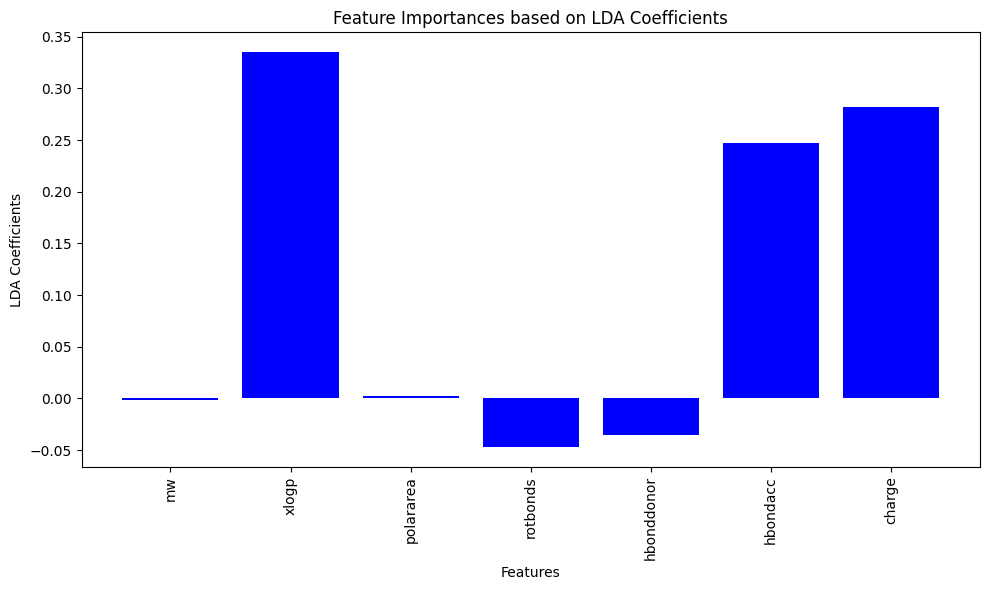

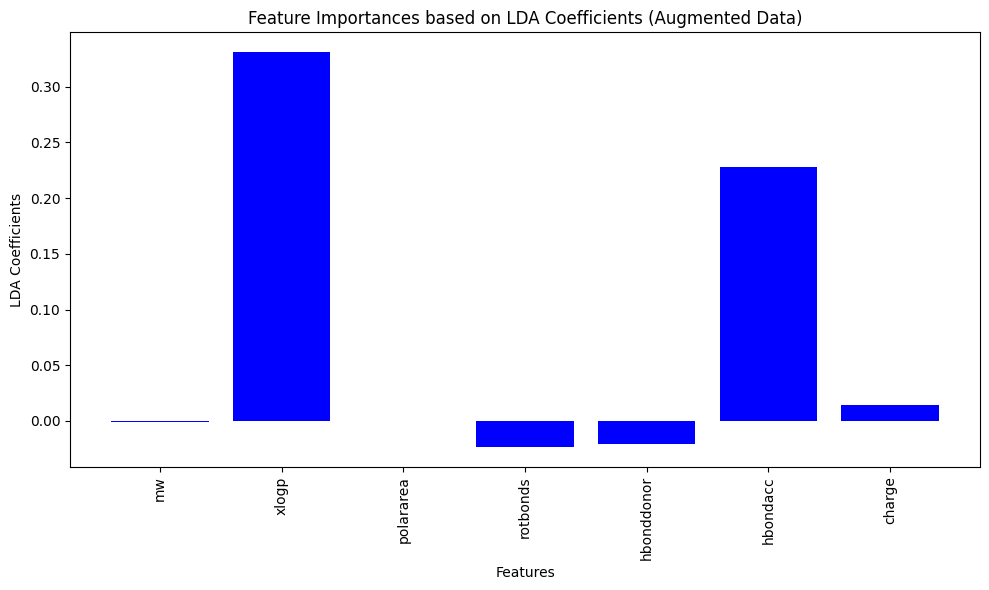

In [19]:
import matplotlib.pyplot as plt
coefficients = lda.coef_[0]  # Les coefficients de la transformation linéaire

# Créer un graphique pour afficher l'importance des caractéristiques
plt.figure(figsize=(10, 6))
plt.bar(X.columns, coefficients, color='blue')
plt.xlabel('Features')
plt.ylabel('LDA Coefficients')
plt.title('Feature Importances based on LDA Coefficients')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

coefficients_augmented = lda_augmented.coef_[0]  # Les coefficients de la transformation linéaire

# Créer un graphique pour afficher l'importance des caractéristiques
plt.figure(figsize=(10, 6))
plt.bar(X.columns, coefficients_augmented, color='blue')
plt.xlabel('Features')
plt.ylabel('LDA Coefficients')
plt.title('Feature Importances based on LDA Coefficients (Augmented Data)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


LDA n'a produit qu'une seule composante principale. Utilisation de n_components=1.


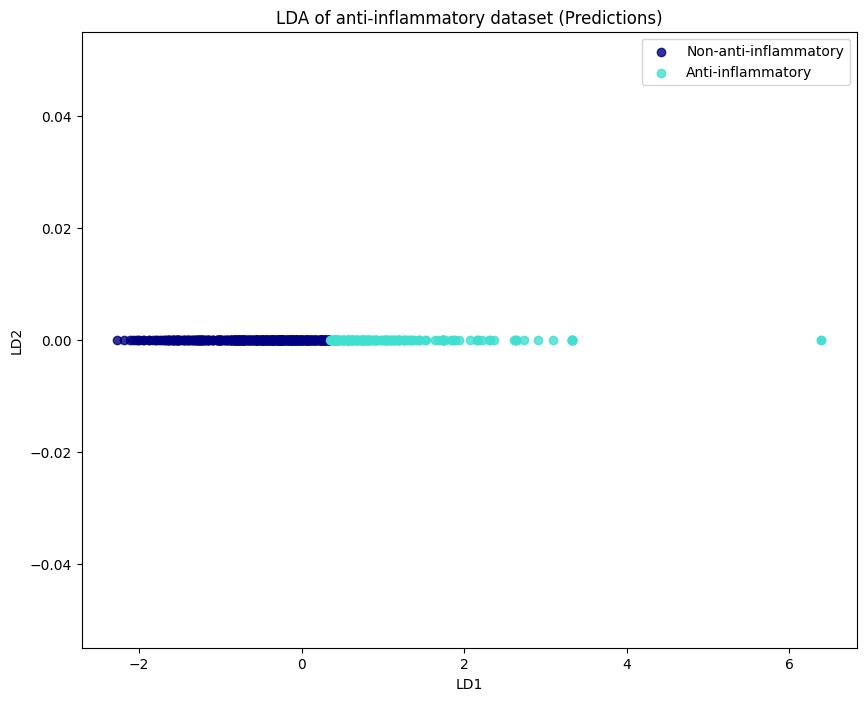

In [27]:
# Vérifier le nombre de composantes
if X_test_lda.shape[1] < 2:
    print("LDA n'a produit qu'une seule composante principale. Utilisation de n_components=1.")
    plt.figure(figsize=(10, 8))
    colors = ['navy', 'turquoise']
    target_names = ['Non-anti-inflammatory', 'Anti-inflammatory']

    for color, i, target_name in zip(colors, lda.classes_, target_names):
        plt.scatter(X_test_lda[y_pred == i], [0] * len(X_test_lda[y_pred == i]), alpha=.8, color=color, label=target_name)

    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('LDA of anti-inflammatory dataset (Predictions)')
    plt.xlabel('LD1')
    plt.ylabel('LD2')
    plt.show()
else:
    # Visualiser les résultats
    plt.figure(figsize=(10, 8))
    colors = ['navy', 'turquoise']
    target_names = ['Non-anti-inflammatory', 'Anti-inflammatory']

    for color, i, target_name in zip(colors, lda.classes_, target_names):
        plt.scatter(X_test_lda[y_pred == i, 0], X_test_lda[y_pred == i, 1], alpha=.8, color=color, label=target_name)

    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('LDA of anti-inflammatory dataset (Predictions)')
    plt.xlabel('LD1')
    plt.ylabel('LD2')
    plt.show()

LDA n'a produit qu'une seule composante principale. Utilisation de n_components=1.


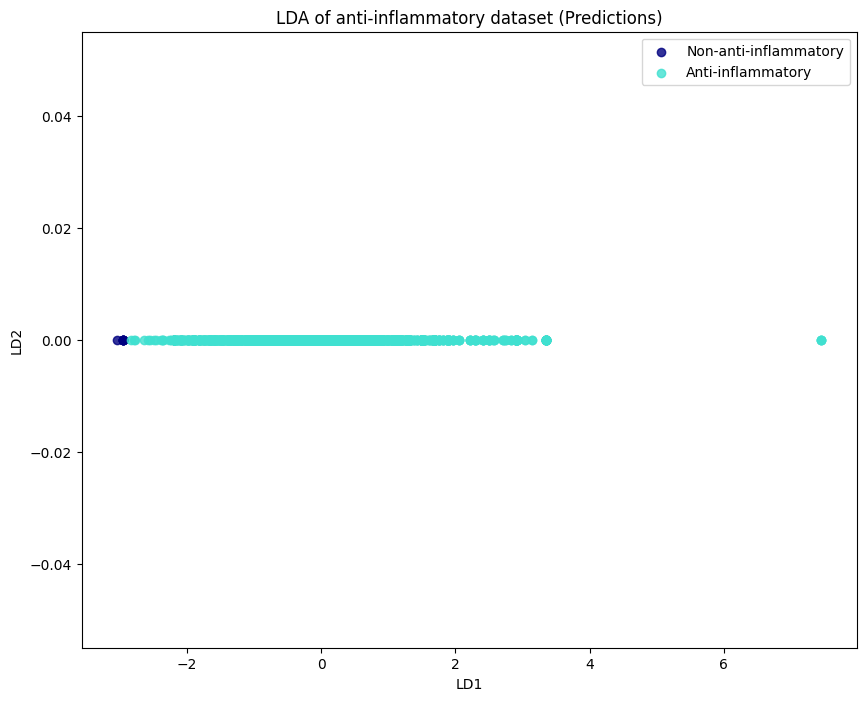

In [93]:
# Vérifier le nombre de composantes
if X_test_lda_augmented.shape[1] < 2:
    print("LDA n'a produit qu'une seule composante principale. Utilisation de n_components=1.")
    plt.figure(figsize=(10, 8))
    colors = ['navy', 'turquoise']
    target_names = ['Non-anti-inflammatory', 'Anti-inflammatory']

    for color, i, target_name in zip(colors, lda.classes_, target_names):
        plt.scatter(X_test_lda_augmented[y_pred_augmented == i], [0] * len(X_test_lda_augmented[y_pred_augmented == i]), alpha=.8, color=color, label=target_name)

    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('LDA of anti-inflammatory dataset (Predictions)')
    plt.xlabel('LD1')
    plt.ylabel('LD2')
    plt.show()
else:
    # Visualiser les résultats
    plt.figure(figsize=(10, 8))
    colors = ['navy', 'turquoise']
    target_names = ['Non-anti-inflammatory', 'Anti-inflammatory']

    for color, i, target_name in zip(colors, lda.classes_, target_names):
        plt.scatter(X_test_lda_augmented[y_pred_augmented == i, 0], X_test_lda_augmented[y_pred_augmented == i, 1], alpha=.8, color=color, label=target_name)

    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('LDA of anti-inflammatory dataset (Predictions)')
    plt.xlabel('LD1')
    plt.ylabel('LD2')
    plt.show()

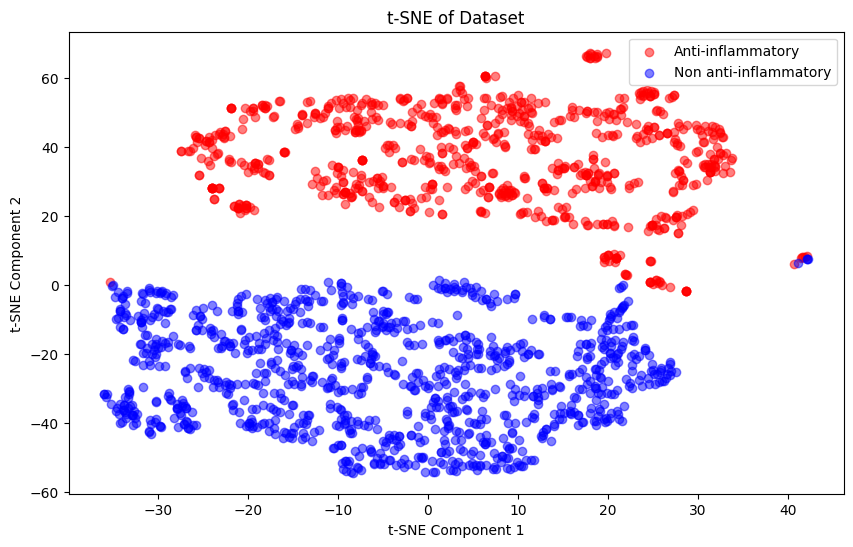

In [89]:
from sklearn.manifold import TSNE


# Normaliser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Créer un DataFrame pour les données t-SNE
df_tsne = pd.DataFrame(data=X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['anti_inflammatory'] = y

# Visualiser les données
plt.figure(figsize=(10, 6))
colors = {1: 'red', 0: 'blue'}
labels = {1: 'Anti-inflammatory', 0: 'Non anti-inflammatory'}

# Créer un scatter plot avec des légendes
for label in labels:
    subset = df_tsne[df_tsne['anti_inflammatory'] == label]
    plt.scatter(subset['TSNE1'], subset['TSNE2'], c=colors[label], label=labels[label], alpha=0.5)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of Dataset')
plt.legend()
plt.show()
